Mount the Drive

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


### Useful imports and plotting functions

In [ ]:
%matplotlib inline

# Python 2/3 compatibility
from __future__ import print_function, division

import itertools
import time

import numpy as np
import matplotlib.pyplot as plt

# Colors from Colorbrewer Paired_12
colors = [[31, 120, 180], [51, 160, 44]]
colors = [(r / 255, g / 255, b / 255) for (r, g, b) in colors]

# functions to show an image
def imshow(img):
    """
    :param img: (PyTorch Tensor)
    """
    # unnormalize
    img = img / 2 + 0.5     
    # Convert tensor to numpy array
    npimg = img.numpy()
    # Color channel first -> color channel last
    plt.imshow(np.transpose(npimg, (1, 2, 0)))


def plot_losses(train_history, val_history):
    x = np.arange(1, len(train_history) + 1)

    plt.figure(figsize=(8, 6))
    plt.plot(x, train_history, color=colors[0], label="Training loss", linewidth=2)
    plt.plot(x, val_history, color=colors[1], label="Validation loss", linewidth=2)
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend(loc='upper right')
    plt.title("Evolution of the training and validation loss")
    plt.show()


## Part B. Identifying Social Statuses in Historical Japanese Artwork



In [ ]:
import time
import numpy as np

import torch
import torch.nn as nn
import torch.nn.init as init
import torch.nn.functional as F

import torchvision
import torchvision.transforms as transforms

# Define default device, we should use the GPU (cuda) if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

#### 'Data loader_pytorch'

In [ ]:
import csv
import os
from PIL import Image
import torch
from torch.utils.data import Dataset


def verify_str_arg(value, valid_values):
    assert value in valid_values
    return value


def image_loader(path):
    with open(path, 'rb') as f:
        img = Image.open(f)
        return img.convert('RGB')


def load_labels(path):
    with open(path, newline='') as csvfile:
        reader = csv.reader(csvfile)
        headers = next(reader)
        return [{
            headers[column_index]: row[column_index]
            for column_index in range(len(row))
        }
                for row in reader]


class Kaokore(Dataset):

    def __init__(self, root, split='train', category='status', transform=None):
        self.root = root = os.path.expanduser(root)

        self.split = verify_str_arg(split, ['train', 'dev', 'test'])

        self.category = verify_str_arg(category, ['gender','status'])

        labels = load_labels(os.path.join(root, 'labels.csv'))
        self.entries = [
            (label_entry['image'], int(label_entry[category]))
            for label_entry in labels
            if label_entry['set'] == split and os.path.exists(
                os.path.join(self.root, 'images_256', label_entry['image']))
        ]
        self.transform = transform

    def __len__(self):
        return len(self.entries)

    def __getitem__(self, index):
        image_filename, label = self.entries[index]

        image_filepath = os.path.join(self.root, 'images_256', image_filename)
        image = image_loader(image_filepath)
        if self.transform is not None:
            image = self.transform(image)

        return image, label


Data augmentation and normalization.

In [ ]:
num_workers = 2
test_batch_size = 32

transform = transforms.Compose(
    [transforms.Resize(128),
     transforms.RandomHorizontalFlip(),
     transforms.ToTensor(),
     transforms.Normalize(mean=(0.5494, 0.5487, 0.5527), std=(0.2025, 0.2025, 0.2026))
     ])

train_set = Kaokore(root='/content/drive/My Drive/Colab Notebooks',split='train',
                    category='status', transform=transform)

train_loader = torch.utils.data.DataLoader(train_set, batch_size=test_batch_size,
                                           num_workers=num_workers)

val_set = Kaokore(root='/content/drive/My Drive/Colab Notebooks',split='dev',
                  category='status', transform=transform)

val_loader = torch.utils.data.DataLoader(val_set+train_set, batch_size=test_batch_size,
                                           num_workers=num_workers)

test_set = Kaokore(root='/content/drive/My Drive/Colab Notebooks',split='test',
                   category='status', transform=transform)

test_loader = torch.utils.data.DataLoader(test_set, batch_size=test_batch_size,
                                           num_workers=num_workers)

classes = ('noble', 'warrior', 'incarnation', 'commoner')

In [ ]:
#loader = torch.utils.data.DataLoader(test_set, batch_size=len(test_set))
#data = next(iter(loader))
#data[0].mean(), data[0].std()

In [ ]:
#transforms.Normalize(mean=(0.5494, 0.5487, 0.5527), std=(0.2025, 0.2025, 0.2026))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


     noble incarnation incarnation   commoner      noble    warrior    warrior   commoner   commoner    warrior    warrior    warrior incarnation    warrior    warrior    warrior      noble incarnation      noble      noble   commoner      noble    warrior incarnation      noble    warrior    warrior      noble      noble   commoner      noble    warrior


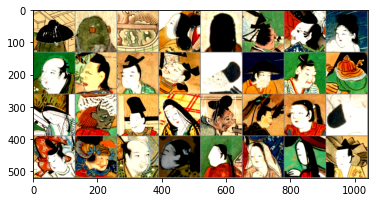

In [ ]:
# get some random training images
dataiter = iter(train_loader)
images, labels = dataiter.next()

# show images
imshow(torchvision.utils.make_grid(images))
# print labels
print(' '.join('{:>10}'.format(classes[labels[j]]) for j in range(test_batch_size)))

In [ ]:
print(len(train_set))
print(len(val_set))
print(len(test_set))

4238
533
527


Network setting - ResNet

In [ ]:
def _weights_init(m):
    classname = m.__class__.__name__
    if isinstance(m, nn.Linear) or isinstance(m, nn.Conv2d):
        init.kaiming_normal_(m.weight)

class LambdaLayer(nn.Module):
    def __init__(self, lambd):
        super(LambdaLayer, self).__init__()
        self.lambd = lambd

    def forward(self, x):
        return self.lambd(x)


class BasicBlock(nn.Module):
    expansion = 1

    def __init__(self, in_planes, planes, stride=1, option='A'):
        super(BasicBlock, self).__init__()
        self.conv1 = nn.Conv2d(in_planes, planes, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(planes)
        self.conv2 = nn.Conv2d(planes, planes, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(planes)

        self.shortcut = nn.Sequential()
        if stride != 1 or in_planes != planes:
            if option == 'A':
                """
                For CIFAR10 ResNet paper uses option A.
                """
                self.shortcut = LambdaLayer(lambda x:
                                            F.pad(x[:, :, ::2, ::2], (0, 0, 0, 0, planes//4, planes//4), "constant", 0))
            elif option == 'B':
                self.shortcut = nn.Sequential(
                     nn.Conv2d(in_planes, self.expansion * planes, kernel_size=1, stride=stride, bias=False),
                     nn.BatchNorm2d(self.expansion * planes)
                )

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))
        out += self.shortcut(x)
        out = F.relu(out)
        return out


class ResNet(nn.Module):
    def __init__(self, block, num_blocks, num_classes=4):
        super(ResNet, self).__init__()
        self.in_planes = 16

        self.conv1 = nn.Conv2d(3, 16, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(16)
        self.layer1 = self._make_layer(block, 16, num_blocks[0], stride=1)
        self.layer2 = self._make_layer(block, 32, num_blocks[1], stride=2)
        self.layer3 = self._make_layer(block, 64, num_blocks[2], stride=2)
        self.linear = nn.Linear(64, num_classes)

        self.apply(_weights_init)

    def _make_layer(self, block, planes, num_blocks, stride):
        strides = [stride] + [1]*(num_blocks-1)
        layers = []
        for stride in strides:
            layers.append(block(self.in_planes, planes, stride))
            self.in_planes = planes * block.expansion

        return nn.Sequential(*layers)

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.layer1(out)
        out = self.layer2(out)
        out = self.layer3(out)
        out = F.avg_pool2d(out, out.size()[3])
        out = out.view(out.size(0), -1)
        out = self.linear(out)
        return out

net = ResNet(BasicBlock, [3, 3, 3])
print(net)

if device == 'cuda':
    net = torch.nn.DataParallel(net)
    cudnn.benchmark = True

ResNet(
  (conv1): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  (bn1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (shortcut): Sequential()
    )
    (1): BasicBlock(
      (conv1): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=

### 3. Define a loss function and optimizer

In [ ]:
import torch.optim as optim

def createLossAndOptimizer(net, learning_rate=0.001):
    # it combines softmax with negative log likelihood loss
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(net.parameters(), lr=learning_rate)
    return criterion, optimizer

### 4. Train the network


This is when things start to get interesting.
We simply have to loop over our data iterator, feed the inputs to the network, and optimize

In [ ]:
def get_train_loader(batch_size):
    return torch.utils.data.DataLoader(train_set, batch_size=batch_size,
                                              num_workers=num_workers)

# Use larger batch size for validation to speed up computation
def get_val_loader(batch_size):
  return torch.utils.data.DataLoader(val_set, batch_size=batch_size,
                                          num_workers=num_workers)

#### Training loop
The training script: it takes ~10s per epoch with batch_size = 32

In [ ]:
def train(net, batch_size, n_epochs, learning_rate):
    """
    Train a neural network and print statistics of the training
    
    :param net: (PyTorch Neural Network)
    :param batch_size: (int)
    :param n_epochs: (int)  Number of iterations on the training set
    :param learning_rate: (float) learning rate used by the optimizer
    """
    print("===== HYPERPARAMETERS =====")
    print("batch_size=", batch_size)
    print("n_epochs=", n_epochs)
    print("learning_rate=", learning_rate)
    print("=" * 30)
    
    train_loader = get_train_loader(batch_size)
    n_minibatches = len(train_loader)

    criterion, optimizer = createLossAndOptimizer(net, learning_rate)
    scheduler = optim.lr_scheduler.MultiStepLR(optimizer, milestones=[30,40], gamma=0.1, last_epoch=-1)
    # Init variables used for plotting the loss
    train_history = []
    val_history = []

    training_start_time = time.time()
    best_error = np.inf
    best_model_path = "/content/drive/My Drive/Colab Notebooks/best_model.pth"
    
    # Move model to gpu if possible
    net = net.to(device)

    for epoch in range(n_epochs):  # loop over the dataset multiple times

        running_loss = 0.0
        print_every = n_minibatches // 10
        start_time = time.time()
        total_train_loss = 0
        
        for i, (inputs, labels) in enumerate(train_loader):

            # Move tensors to correct device
            inputs, labels = inputs.to(device), labels.to(device)

            # zero the parameter gradients
            optimizer.zero_grad()

            # forward + backward + optimize
            outputs = net(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            # print statistics
            running_loss += loss.item()
            total_train_loss += loss.item()

            # print every 10th of epoch
            if (i + 1) % (print_every + 1) == 0:    
                print("Epoch {}, {:d}% \t train_loss: {:.2f} took: {:.2f}s".format(
                      epoch + 1, int(100 * (i + 1) / n_minibatches), running_loss / print_every,
                      time.time() - start_time))
                running_loss = 0.0
                start_time = time.time()

        train_history.append(total_train_loss / len(train_loader))

        total_val_loss = 0
        val_loader = get_val_loader(batch_size)
        # Do a pass on the validation set
        # We don't need to compute gradient, so we use torch.no_grad() to save memory and computation
        with torch.no_grad():
          for inputs, labels in val_loader:
              inputs, labels = inputs.to(device), labels.to(device)
              predictions = net(inputs)
              val_loss = criterion(predictions, labels)
              total_val_loss += val_loss.item()
            
        val_history.append(total_val_loss / len(val_loader))
        # Save model that performs best on validation set
        if total_val_loss < best_error:
            best_error = total_val_loss
            torch.save(net.state_dict(), best_model_path)

        print("Validation loss = {:.2f}".format(total_val_loss / len(val_loader)))
        scheduler.step()

    print("Training Finished, took {:.2f}s".format(time.time() - training_start_time))
    
    # Load best model
    net.load_state_dict(torch.load(best_model_path))

    return train_history, val_history
    
# train the model
train_history, val_history = train(net, batch_size=128, n_epochs=50, learning_rate=0.001)

===== HYPERPARAMETERS =====
batch_size= 128
n_epochs= 50
learning_rate= 0.001
Epoch 1, 11% 	 train_loss: 2.80 took: 2.25s
Epoch 1, 23% 	 train_loss: 1.54 took: 1.56s
Epoch 1, 35% 	 train_loss: 1.55 took: 1.62s
Epoch 1, 47% 	 train_loss: 1.36 took: 1.52s
Epoch 1, 58% 	 train_loss: 1.41 took: 1.54s
Epoch 1, 70% 	 train_loss: 1.45 took: 1.46s
Epoch 1, 82% 	 train_loss: 1.37 took: 1.59s
Epoch 1, 94% 	 train_loss: 1.33 took: 1.57s
Validation loss = 0.93
Epoch 2, 11% 	 train_loss: 1.36 took: 2.15s
Epoch 2, 23% 	 train_loss: 1.31 took: 1.52s
Epoch 2, 35% 	 train_loss: 1.40 took: 1.61s
Epoch 2, 47% 	 train_loss: 1.27 took: 1.49s
Epoch 2, 58% 	 train_loss: 1.33 took: 1.56s
Epoch 2, 70% 	 train_loss: 1.39 took: 1.48s
Epoch 2, 82% 	 train_loss: 1.34 took: 1.60s
Epoch 2, 94% 	 train_loss: 1.24 took: 1.56s
Validation loss = 0.93
Epoch 3, 11% 	 train_loss: 1.30 took: 2.08s
Epoch 3, 23% 	 train_loss: 1.29 took: 1.63s
Epoch 3, 35% 	 train_loss: 1.34 took: 1.52s
Epoch 3, 47% 	 train_loss: 1.24 took: 1.

Now, let's look at the evolution of the losses

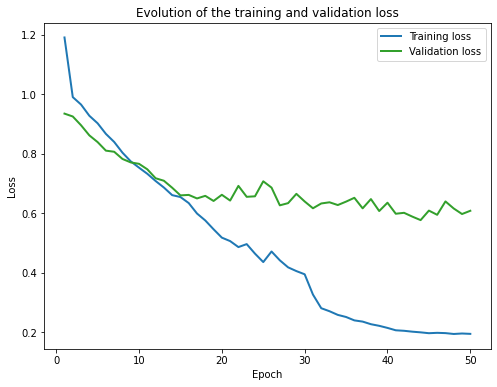

In [ ]:
plot_losses(train_history, val_history)

### 4. Train the network

In [ ]:
def dataset_accuracy(net, data_loader, name=""):
    net.eval()
    net = net.to(device)
    correct = 0
    total = 0
    for images, labels in data_loader:
      images, labels = images.to(device), labels.to(device)
      outputs = net(images)
      _,predictions = torch.max(outputs, 1)
      total += labels.size(0)
      correct += (predictions == labels).sum()
      
    accuracy = 100 * float(correct) / total
    print('Accuracy of the network on the {} {} images: {:.2f} %'.format(total, name, accuracy))

def train_set_accuracy(net):
    dataset_accuracy(net, train_loader, "train")

def val_set_accuracy(net):
    dataset_accuracy(net, val_loader, "val")

def test_set_accuracy(net):
    dataset_accuracy(net, test_loader, "test")

def compute_accuracy(net):
    train_set_accuracy(net)
    val_set_accuracy(net)
    test_set_accuracy(net)
    
print("Computing accuracy...")
compute_accuracy(net)

Computing accuracy...
Accuracy of the network on the 4238 train images: 93.25 %
Accuracy of the network on the 4771 val images: 91.64 %
Accuracy of the network on the 527 test images: 79.89 %
